<a href="https://colab.research.google.com/github/jacquesbilombe/CRM-RFM-Analysis/blob/main/CustomerClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset for this project can be found at the [UC Irvine public repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II) or at [Kaggle](https://www.kaggle.com/datasets/ddosad/auto-sales-data). This project serves as a case study for the Data Science and Analytics course at PUC RIO. For more information, please refer to the project README.

In [28]:
import os
import csv
import sys
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from pathlib import Path
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

## Other configurations

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

url = "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"

# Download the zip file
!wget -q $url

# Unzip the file
!unzip -q online+retail+ii.zip

replace online_retail_II.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Exploratory Data Analysis

In [2]:
# Read the excel file
DF = pd.read_excel("online_retail_II.xlsx")


In [3]:
df = DF.copy()
# Display the dataframe
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
def summary_data(df, head=5):
    func = {
        "Head": df.head(head),
        "Info": df.info(),
        "Shape": df.shape,
        "Ndim": df.ndim,
        "Null": df.isnull().sum(),
        "Describe": df.describe().T
    }

    for n, f in func.items():
        print("\n################### ", n, " ###################\n")
        if isinstance(f, pd.DataFrame) or isinstance(f, pd.Series):
            print(f)
        else:
            print(f)

summary_data(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB

###################  Head  ###################

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY

- The summary function revealed null values in the dataset and negative values in the "Quantity" column, indicating potential refunds requested by customers. For the purposes of this analysis, these entries will be removed from the database.

- The dataset only has the quantity of items saled and their price, a column of Total Prie will be aggregate to the database

In [5]:
# Dropping Missing Values
df = df.dropna()

df = df[df['Quantity'] > 0]

# Total price column
df["TotalPrice"] = df["Quantity"] * df["Price"]
df.tail(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom,3.90


## RFM Analysis
CRM Analytics employs various methods to gain insights into customer behavior, with RFM Analysis being one of the prominent techniques. RFM stands for Recency, Frequency, and Monetary, representing distinct aspects of customer engagement. Each of these components provides valuable insights into customer behavior and preferences.

- Recency is determined by computing the time elapsed since a customer's last interaction, typically a purchase, up to the date of analysis. This calculation entails subtracting the customer's last shopping date from the analysis date, yielding a duration. A shorter duration indicates a more recent shopping activity, implying a higher likelihood of brand retention and future purchases. Moreover, it serves as a means to identify customers who have refrained from shopping for an extended period, enabling targeted efforts to re-engage them with the store or brand. For this analysis, we'll consider today's date as the date of the last purchase plus one day to avoid "null" value. If this doesn't apply to your situation, please provide the date in string format `YYYY-MM-DD` in the following function.
- Frequency represents the frequency with which a customer makes purchases. By analyzing purchase patterns, businesses can discern recurring buying cycles among customers. Armed with this knowledge, proactive measures can be implemented to anticipate when customers are likely to return to the store or when they may have specific needs. Leveraging insights into purchasing frequencies enables businesses to strategically engage with customers through timely reminders or targeted marketing initiatives.
- The monetary value represents the total amount of money spent by a customer through their purchases, reflecting their overall expenditure. While this metric effectively identifies high-spending customers, it also poses the risk of overlooking those who spend smaller amounts or are new to the business. Consequently, solely focusing on monetary value may inadvertently alienate certain customer segments. Thus, businesses should adopt a balanced approach, considering other factors such as recency and frequency, to ensure inclusive and effective customer engagement strategies.

The script utilizes `pd.groupby` on the "CustomerID" to compute the RFM metrics and consolidate transaction data for each customer. This approach enables the algorithm to analyze RFM metrics on a per-customer basis, offering valuable insights into their purchasing patterns and overall interaction with the business.


In [6]:
def rfm_date(df, to_day):
  if to_day == "":
    return df["InvoiceDate"].max() + pd.Timedelta(days=1)
  else:
    # Check if the given date value if correct
    # before executing the code and deal with the error
    try:
      return datetime.strptime(to_day, "%Y-%m-%d")
    except ValueError as e:
      print("\n Wrong date value, please try againg with this format 'YYYY-MM-DD'")
      sys.exit(0)


rfm = df.groupby('Customer ID').agg({
                            'InvoiceDate': lambda InvoiceDate: (rfm_date(df=df, to_day="") - InvoiceDate.max()).days,  # Recency
                            'Invoice': lambda Invoice: Invoice.nunique(),  # Frequency
                            'TotalPrice': lambda TotalPrice: TotalPrice.sum()  # Monetary
                            })

# Rename the columns to recency, frequency, and monetary
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm = rfm.reset_index()
rfm.head(5)

,Customer ID,Recency,Frequency,Monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1323.32
2,12348.0,74,1,222.16
3,12349.0,43,3,2671.14
4,12351.0,11,1,300.93


In [7]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,4314.0,15348.880389,1700.930104,12346.0,13883.25,15348.50,16833.7500,18287.00
Recency,4314.0,91.269124,96.943482,1.0,18.00,53.00,136.0000,374.00
Frequency,4314.0,4.454103,8.168658,1.0,1.00,2.00,5.0000,205.00
Monetary,4314.0,2047.288659,8912.523243,0.0,307.95,705.55,1722.8025,349164.35


In [8]:
# Customers which monetery value igual to zero isn't what we want to segment for the next steps
rfm = rfm[rfm['Monetary'] > 0]
rfm

,Customer ID,Recency,Frequency,Monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1323.32
2,12348.0,74,1,222.16
3,12349.0,43,3,2671.14
4,12351.0,11,1,300.93
...,...,...,...,...
4309,18283.0,18,6,641.77
4310,18284.0,67,1,461.68
4311,18285.0,296,1,427.00
4312,18286.0,112,2,1296.43


### RFM segmentation

Beside several methods to calculate the RFM SCORE, we'll use an unsupervised machine learning approach; a classification algorithm - [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

K-means gives the best result under the following conditions:

- Data distribution is not skewed
- Data is standardised (i.e. mean of 0 and standard deviation of 1).

#### Features Selection

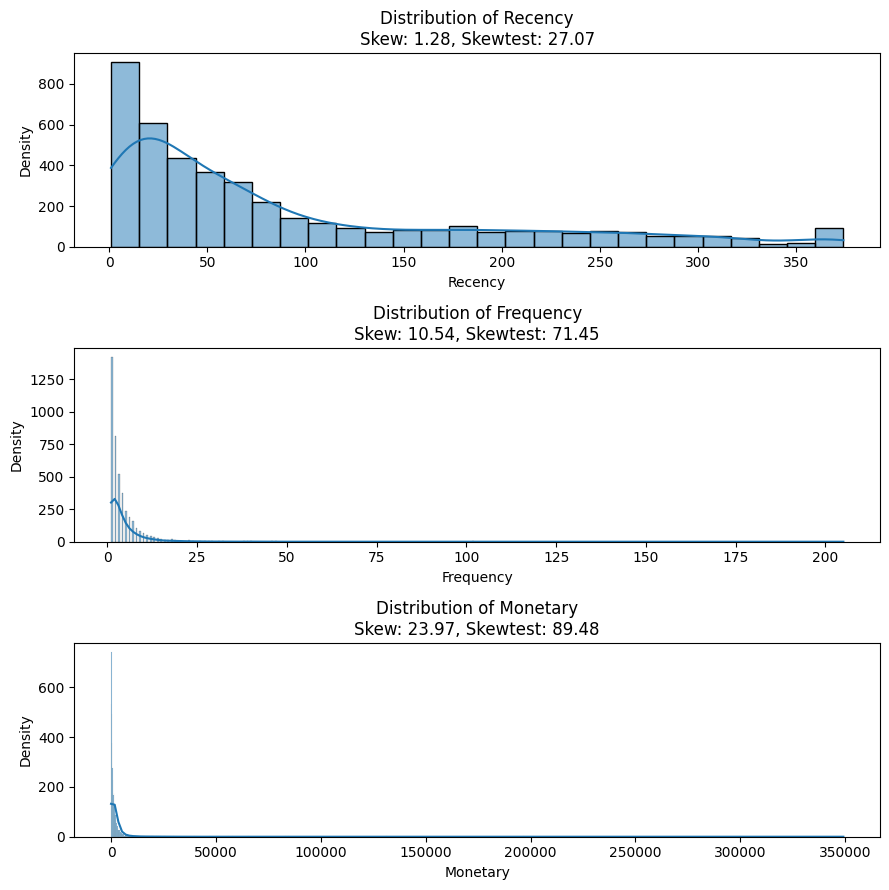

In [15]:
## Function to check skewness
def check_skew(df_skew, columns):
    fig, axes = plt.subplots(len(columns), 1, figsize=(9, 9))

    for i, column in enumerate(columns):
        skew = stats.skew(df_skew[column])
        skewtest = stats.skewtest(df_skew[column])

        sns.histplot(df_skew[column], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {column}\nSkew: {skew:.2f}, Skewtest: {skewtest.statistic:.2f}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

check_skew(rfm, ['Recency', 'Frequency', 'Monetary'])

Due to significant skewness in the data, we will apply log transformations to mitigate skewness for each variable. To meet the requirements of the log transformation, As all values in our dataset is positive, we don't need a slight constant to make its positive.

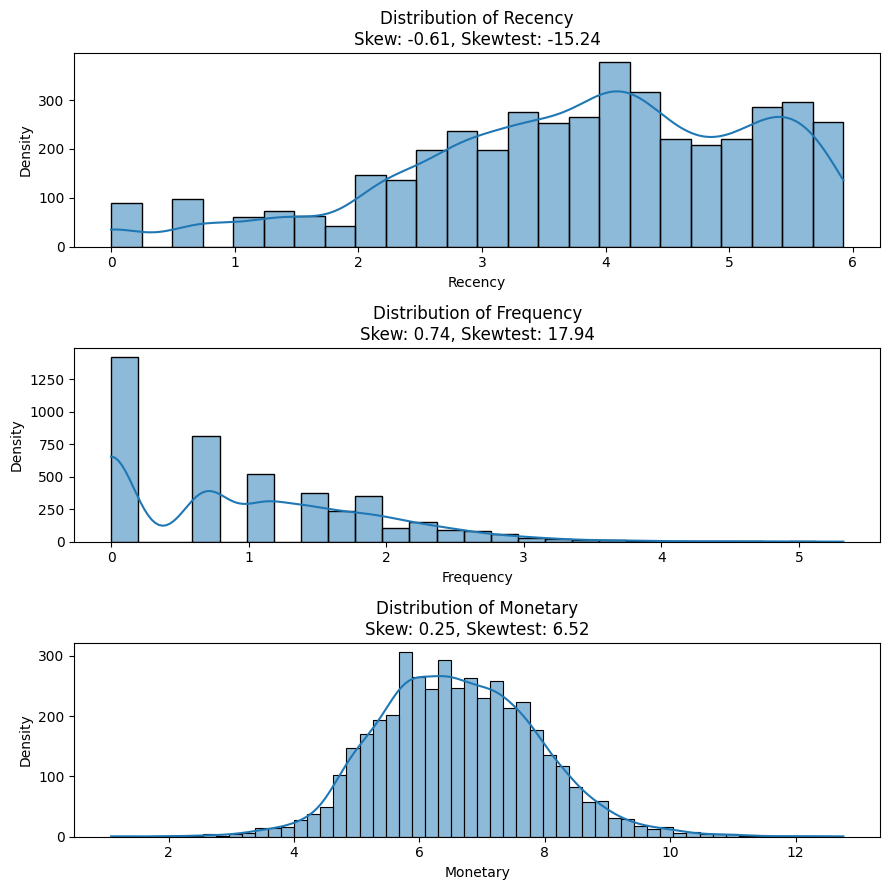

In [16]:
#Removing Skewness
df_rfm_log = np.log(rfm)
check_skew(df_rfm_log, ['Recency', 'Frequency', 'Monetary'])

#### Standardization

In [17]:
df_rfm_log.tail()

,Customer ID,Recency,Frequency,Monetary
4309,9.813727,2.890372,1.791759,6.464230
4310,9.813782,4.204693,0.000000,6.134872
4311,9.813836,5.690359,0.000000,6.056784
4312,9.813891,4.718499,0.693147,7.167370
4313,9.813946,2.890372,1.386294,7.760343


In [18]:
# Standardize the features
scaler = StandardScaler()
scaler.fit(df_rfm_log)
RFM_Table_scaled = scaler.transform(df_rfm_log)

# To Dataframe
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=['Customer ID', 'Recency', 'Frequency', 'Monetary'])
RFM_Table_scaled.head()

,Customer ID,Recency,Frequency,Monetary
0,-1.890600,0.942545,1.562935,-0.538792
1,-1.889876,-1.940934,-0.315366,0.448030
2,-1.889152,0.365552,-1.079079,-0.942189
3,-1.888429,-0.025067,0.131378,0.995207
4,-1.886981,-1.006034,-1.079079,-0.705763


####  Clusters number

A different number of clusters can lead us to completely different results. Therefore, it’s important to get the optimal number of clusters for our analysis. To find it out, we will apply `Elbow and Siloute methods`.

##### Elbow Method

In [20]:
distortions = []
inertias = []

mapping1 = {}
mapping2 = {}

# Define the range of K values
K = range(1, 10)

# Loop over each value of K
for k in K:
    # Build and fit the K-means model
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled)

    # Calculate distortion (average distance to nearest cluster center) for the current K value
    distortion = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / RFM_Table_scaled.shape[0]
    distortions.append(distortion)

    # Calculate inertia for the current K value
    inertia = kmeanModel.inertia_
    inertias.append(inertia)

    # Map the distortion and inertia values to the current K value
    mapping1[k] = distortion
    mapping2[k] = inertia

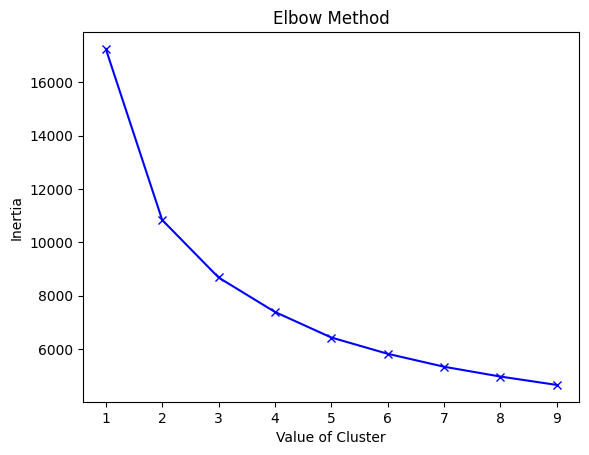

In [22]:
# Plot the result
plt.plot(K, inertias, 'bx-')
plt.xlabel('Value of Cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

##### Siloute Method

In [27]:
# For Silhoute Method, the cluster must be 2 or more; meaning KMeans could classified the dataset
K_clusters = range(2,10)
for k in K_clusters:
  # Initialise Kmeans
  Kmeans_model = KMeans(n_clusters=k, max_iter=50).fit(RFM_Table_scaled)
  cluster_labels = Kmeans_model.labels_

  # Silhoute score
  silhoute = silhouette_score(RFM_Table_scaled, cluster_labels)
  print(f"For k_clust {k}, the silhoute score {silhoute}")

For k_clust 2, the silhoute score 0.3209753738047957
For k_clust 3, the silhoute score 0.27104911591006847
For k_clust 4, the silhoute score 0.2523957552898433
For k_clust 5, the silhoute score 0.24408712132644741
For k_clust 6, the silhoute score 0.24174987395729539
For k_clust 7, the silhoute score 0.24395894489209485
For k_clust 8, the silhoute score 0.23077312223880272
For k_clust 9, the silhoute score 0.22983292120426776


Based on the above two methods, it looks like 3 is the ideal number of cluster for this analysis, however, for a business requirements, we can go ahead with fewer or more clusters. We will be trying our analysis with 3,4 and 5 clusters.
- K = 3, drastic change of the Silhoute Score or Inertia
- K = 5, the Silhoute Score started to stabilize

For a better vizualisation, we'll use [TSE graph](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to have a mention of the clusters in each cenario.

##### TSE-Graph

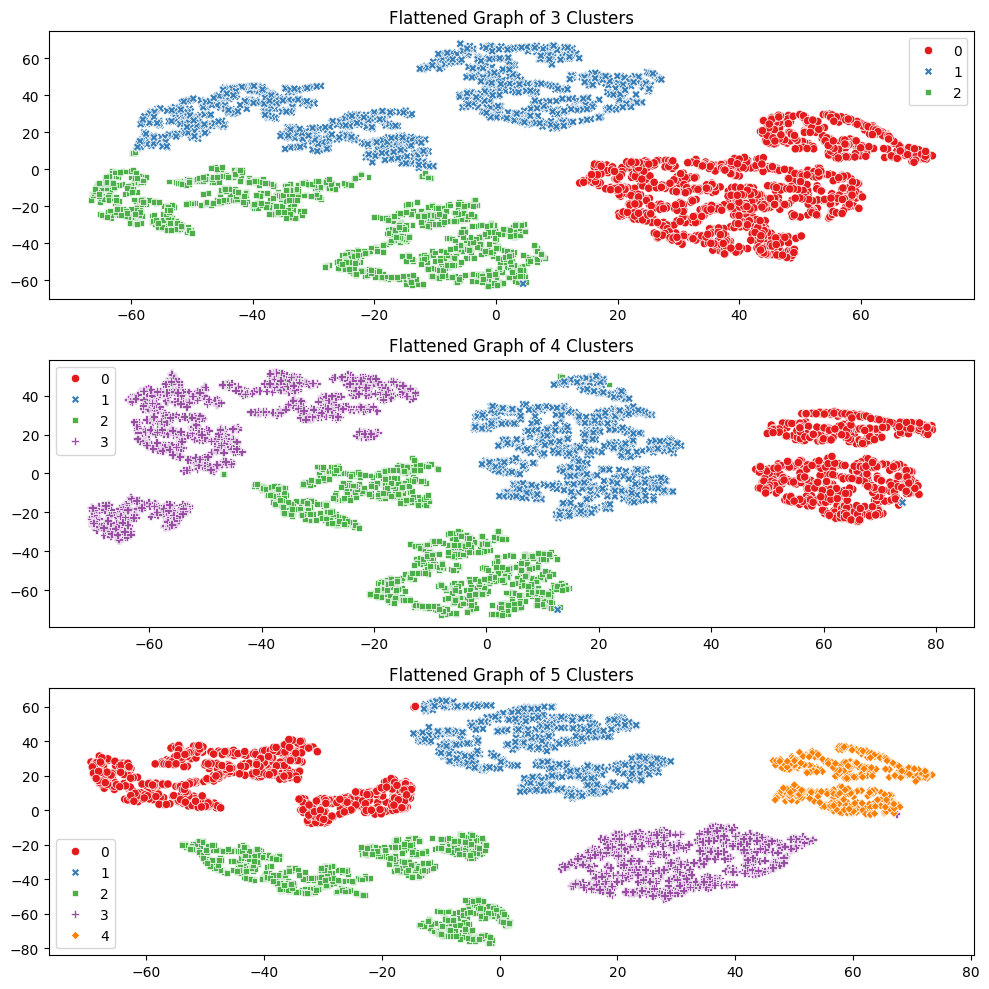

In [31]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):

    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
    # Extract cluster labels
    cluster_labels = kmeans.labels_

    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)

    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)

    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

    return df_new
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, df_rfm_log)
plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, df_rfm_log)
plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, df_rfm_log)
plt.tight_layout()

From the flattened graphs, the elbow and the silhoutte methods, it is evident that having a cluster value of `4 segments our customers` well. We could also go for a higher number of clusters, it completely depends on how the company wants to segment their customers.

#### Costumers Segmentation

In [33]:
df_rfm_k4.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           2.0       2.0      8.0   814
1           3.0       1.0      7.0  1093
2           4.0       1.0      6.0  1231
3           5.0       0.0      5.0  1174

What does each cluster represent?
- The first cluster belongs to the “Best Customers” segment which we saw earlier as they purchase recently (R=1), frequent buyers (F=1), and spent the most (M=1).
- Customers in the second cluster can be interpreted as passerby customers as their last purchase is long ago (R=4), purchased very few (F=4) and spent little (M=4). The company has to come up with new strategies to make them permanent members.
- The third cluster is more related to the “Almost Lost” segment as they Haven’t purchased for some time(R=3) but used to purchase frequently and spent a lot.
- The last cluster is very Loyal Customers and they also spent a lot.

Finally, we'll cluster the customer based on the CRM rules:
- Hibernating
- At Risk
- Cant loose
- About to sleep
- Need attention
- Loyal customers
- Promising
- New customers
- Potential loyalists
- Champions

In [56]:
# Rewrite the Customer ID column with it original value
df_final = RFM_Table_scaled.copy()
df_final.loc[:,'Customer ID'] = rfm['Customer ID'].astype('str')

In [57]:
# We'll apply the KMeans on [Recency, Frequency,	Monetary]
# to have more detail before to create the RFM Score
def apply_kmeans(df_final):

  # Apply KMeans on Recency
  kmeans_recency = KMeans(n_clusters=4)
  kmeans_recency.fit(df_final['Recency'].values.reshape(-1, 1))
  df_final['Recency_Cluster'] = (kmeans_recency.labels_+1).astype('str')

  # Apply KMeans on Frequency
  kmeans_frequency = KMeans(n_clusters=4)
  kmeans_frequency.fit(df_final['Frequency'].values.reshape(-1, 1))
  df_final['Frequency_Cluster'] = (kmeans_frequency.labels_+1).astype('str')

  # Apply KMeans on Monetary
  kmeans_monetary = KMeans(n_clusters=4)
  kmeans_monetary.fit(df_final['Monetary'].values.reshape(-1, 1))
  df_final['Monetary_Cluster'] = (kmeans_monetary.labels_+1).astype('str')

  return df_final

df_final = apply_kmeans(df_final)
df_final['RFM_Score'] = df_final['Recency_Cluster'] + df_final['Frequency_Cluster']
df_final.head()


,Customer ID,Recency,Frequency,Monetary,Recency_Cluster,Frequency_Cluster,Monetary_Cluster,RFM_Score
0,12346.0,0.942545,1.562935,-0.538792,1,1,4,11
1,12347.0,-1.940934,-0.315366,0.448030,4,2,2,42
2,12348.0,0.365552,-1.079079,-0.942189,3,3,1,33
3,12349.0,-0.025067,0.131378,0.995207,3,2,2,32
4,12351.0,-1.006034,-1.079079,-0.705763,2,3,4,23


##### Naming the Segments

In [58]:
# Converting RF_SCORE to Segment Name with Regex
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Cant loose',
    r'3[1-2]': 'About to sleep',
    r'33': 'Need attention',
    r'[3-4][4-5]': 'Loyal customers',
    r'41': 'Promising',
    r'51': 'New customers',
    r'[4-5][2-3]': 'Potential loyalists',
    r'5[4-5]': 'Champions'
    }

df_final['Segment'] = df_final['RFM_Score'].replace(seg_map, regex=True)
df_customers = df_final[['Customer ID','Segment']]
df_customers

,Customer ID,Segment
0,12346.0,Hibernating
1,12347.0,Potential loyalists
2,12348.0,Need attention
3,12349.0,About to sleep
4,12351.0,At Risk
...,...,...
4307,18280.0,At Risk
4308,18281.0,Need attention
4309,18283.0,At Risk
4310,18284.0,Hibernating


#### Conclusion

To conclude, we saw how we can segment our customer depending on our business requirements. You can perform RFM for your entire customer base, or just a subset. For example, you may first segment customers based on a geographical area or other demographics, and then by RFM for historical, transaction-based behaviour segments.

RFM analysis can help in answering many questions with respect to their customers and this can help companies to make marketing strategies for their customers, retaining their slipping customers and providing recommendations to their customer based on their interest.

We used the K-means algorithm to segment our customer in various clusters having similar similarity. I think K-means did a pretty good job here.